# Comparativa de algoritmos clasificadores

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, scikit-learn

Software versions
Python 3.5.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.9.16 gentoo x86_64 with debian stretch sid
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.0
pandas 0.19.2
scikit-learn 0.18.1
Fri May 05 17:37:38 2017 UTC

In [2]:
import os
import sys
sys.path.append("../src/")

import random
from IPython.display import display
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from multioutput_chained import ChainedMultiOutputClassifier
from sklearn.preprocessing import StandardScaler
import ml_plots as mp
import scoring_functions as sf
import warnings
import time
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
matplotlib.rcParams.update({'font.size': 12})

In [3]:
IN_OPTIONS = ['IN_CR', 'IN_CS', 'IN_DS', 'is_Table', 'is_Columnar',
              'is_Int', 'is_Float', 'is_String', 'Type_Size', 'Chunk_Size',
              'Mean', 'Median', 'Sd', 'Skew', 'Kurt', 'Min', 'Max', 'Q1',
              'Q3', 'N_Streaks', 'BLZ_CRate', 'BLZ_CSpeed', 
              'BLZ_DSpeed', 'LZ4_CRate', 'LZ4_CSpeed', 'LZ4_DSpeed']
OUT_CODEC = ['Blosclz', 'Lz4', 'Lz4hc', 'Zstd']
OUT_FILTER = ['Noshuffle', 'Shuffle', 'Bitshuffle'] 
OUT_LEVELS = ['CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8', 'CL9']
OUT_BLOCKS = ['Block_8', 'Block_16', 'Block_32', 'Block_64', 'Block_128',
              'Block_256', 'Block_512', 'Block_1024', 'Block_2048']
OUT_OPTIONS = OUT_CODEC + OUT_FILTER + OUT_LEVELS + OUT_BLOCKS
CUSTOM_IN = ['IN_CS', 'IN_DS', 'IN_CR', 'BLZ_CRate', 'Sd', 'BLZ_CSpeed',
             'Mean', 'Kurt', 'Skew', 'Max', 'Min', 'N_Streaks']
CHUNK_ID = ['Filename', 'DataSet', 'Table', 'Chunk_Number']

In [4]:
df = pd.read_csv('../data/training_data.csv', sep='\t')
rfc = RandomForestClassifier(
    n_estimators=20, max_features=8, max_depth=12, bootstrap=False,
    criterion='entropy')
svc = MultiOutputClassifier(
    SVC(C=1000, gamma=0.1, decision_function_shape='ovr'))
lsvc = MultiOutputClassifier(LinearSVC())
knc = KNeighborsClassifier(n_neighbors=5, weights='distance')
lda = MultiOutputClassifier(LinearDiscriminantAnalysis())
lrc = MultiOutputClassifier(LogisticRegression(solver='newton-cg'))
names = ['RandomForest', 'SVM-rbf', 'SVM-linear', 'KNeighbors', 'LDA', 
         'Logit']
classifiers = [rfc, svc, lsvc, knc, lda, lrc]

In [5]:
rfc_ch = ChainedMultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=20, max_features=8, max_depth=12, bootstrap=False,
        criterion='entropy'))
svc_ch = ChainedMultiOutputClassifier(
    SVC(C=1000, gamma=0.1, decision_function_shape='ovr'))
lsvc_ch = ChainedMultiOutputClassifier(LinearSVC())
knc_ch = ChainedMultiOutputClassifier(
    KNeighborsClassifier(n_neighbors=5, weights='distance'))
lda_ch = ChainedMultiOutputClassifier(LinearDiscriminantAnalysis())
lrc_ch = ChainedMultiOutputClassifier(
    LogisticRegression(solver='newton-cg'))
classifiers_ch = [rfc_ch, svc_ch, lsvc_ch, knc_ch, lda_ch, lrc_ch]

In [6]:
def train_and_test(train_df, test_df, detailed=False):
    scaler = StandardScaler().fit(train_df[CUSTOM_IN].values)
    X_train, Y_train = (scaler.transform(train_df[CUSTOM_IN].values), 
                        train_df[OUT_OPTIONS].values)
    X_test, Y_test = (scaler.transform(test_df[CUSTOM_IN].values), 
                      test_df[OUT_OPTIONS].values)
    scores = []
    for i, clf in enumerate(classifiers):
        clf.fit(X_train, Y_train)
        if detailed:
            classifiers_ch[i].fit(X_train, Y_train)
            scores.append(sf.balanced(classifiers_ch[i], X_test, Y_test))
            scores.append(sf.balanced(clf, X_test, Y_test))
            scores.append(sf.codec(clf, X_test, Y_test))
            scores.append(sf.filter_(clf, X_test, Y_test))
            scores.append(sf.c_level_nice(clf, X_test, Y_test))
            scores.append(sf.block_nice(clf, X_test, Y_test))
        else:
            scores.append(sf.balanced(clf, X_test, Y_test))
    return scores
def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.2f' % (height),
                ha='center', va='bottom')
def plot_clf_scores(title, x_labels, detailed=False):
    fig = plt.figure(figsize=(20, 8))
    width = 0.14
    if detailed:
        ind = np.arange(6)
    else:
        ind = np.arange(len(filenames))
    ax = fig.add_subplot(111)
    colors = ['#5AC8FA', '#FFCC00', '#FF9500', '#007AFF', '#4CD964',
              '#FF3B30']
    if detailed:
        colors = ['#FF3B30', '#4CD964', '#FFCC00', '#FF9500', '#5AC8FA',
                  '#007AFF']
    rects = []
    if detailed:
        for i in range(6):
            rects.append(
                ax.bar(ind + width * i, 
                       [scores[i + j * 6] for j in range(len(names))], 
                       width, color=colors[i]))
    else:
        for i, name in enumerate(names):
            rects.append(
                ax.bar(ind + width * i,
                       [e[i] for e in all_scores],
                       width, color=colors[i]))
    if detailed:
        ax.legend([rec[0] for rec in rects],
                  ['Chained_Balanced', 'Balanced', 'Codec', 'Filter', 'CL',
                   'Block'],  loc='lower left', bbox_to_anchor=(1, 0.05))  
    else:
        ax.legend([rec[0] for rec in rects], names,  loc='lower left',
                  bbox_to_anchor=(1, 0.05))   
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(ind + width * 2.5)
    ax.set_xticklabels(x_labels)
    for rec in rects:
        autolabel(ax, rec)

## Puntuaciones CV-Fichero

In [7]:
all_scores = []
filenames = []
for filename in df.drop_duplicates(subset=['Filename'])['Filename']:
    filenames.append(filename)
    test_df = df[df.Filename == filename]
    train_df = df[df.Filename != filename]
    all_scores.append(train_and_test(train_df, test_df))

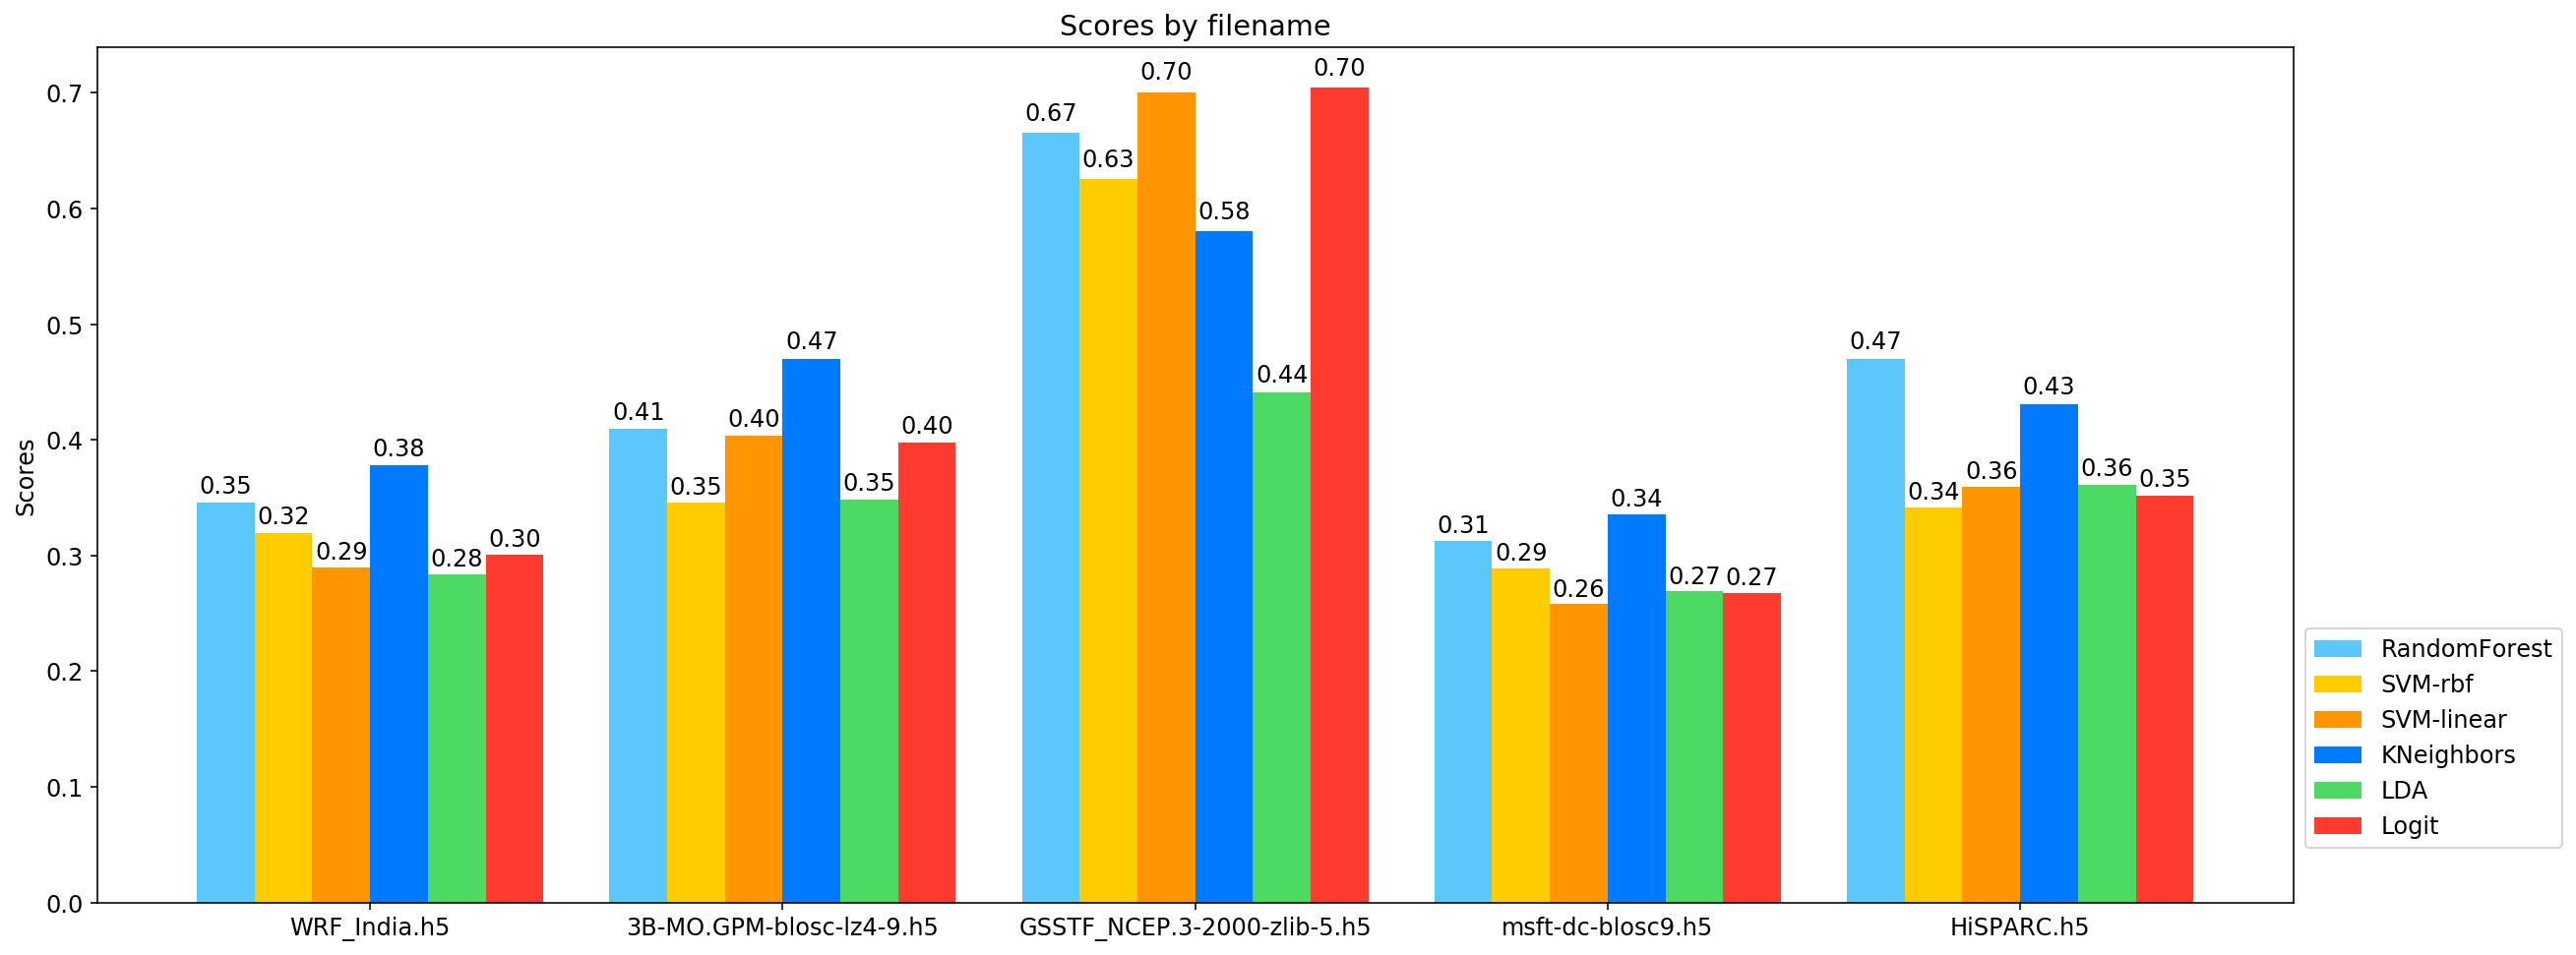

In [8]:
plot_clf_scores('Scores by filename', filenames)

## Puntuaciones CV-DataSets

In [9]:
dataset_rows = []
set_id = ['Filename', 'DataSet', 'Table']
for index, row in df.drop_duplicates(
    subset=['Filename', 'DataSet', 'Table'])[set_id].iterrows():
    dataset_rows.append(row)
N = len(dataset_rows)
split_size = N // 5
total = list(range(N))
current = total
test_indices = []
for i in range(5):
    test = random.sample(current, N // 5)
    test_indices.append(test)
    current = [x for x in current if x not in test]

all_scores = []
for i in range(5):
    train_i = [x for x in total if x not in test_indices[i]]
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for j in train_i:
        train_df = train_df.append(
            df[(df.Filename == dataset_rows[j]['Filename']) & 
               (df.DataSet == dataset_rows[j]['DataSet']) &
               (df.Table == dataset_rows[j]['Table'])])
    for k in test_indices[i]:
        test_df = test_df.append(
            df[(df.Filename == dataset_rows[k]['Filename']) &
               (df.DataSet == dataset_rows[k]['DataSet']) &
               (df.Table == dataset_rows[k]['Table'])])
    all_scores.append(train_and_test(train_df, test_df))

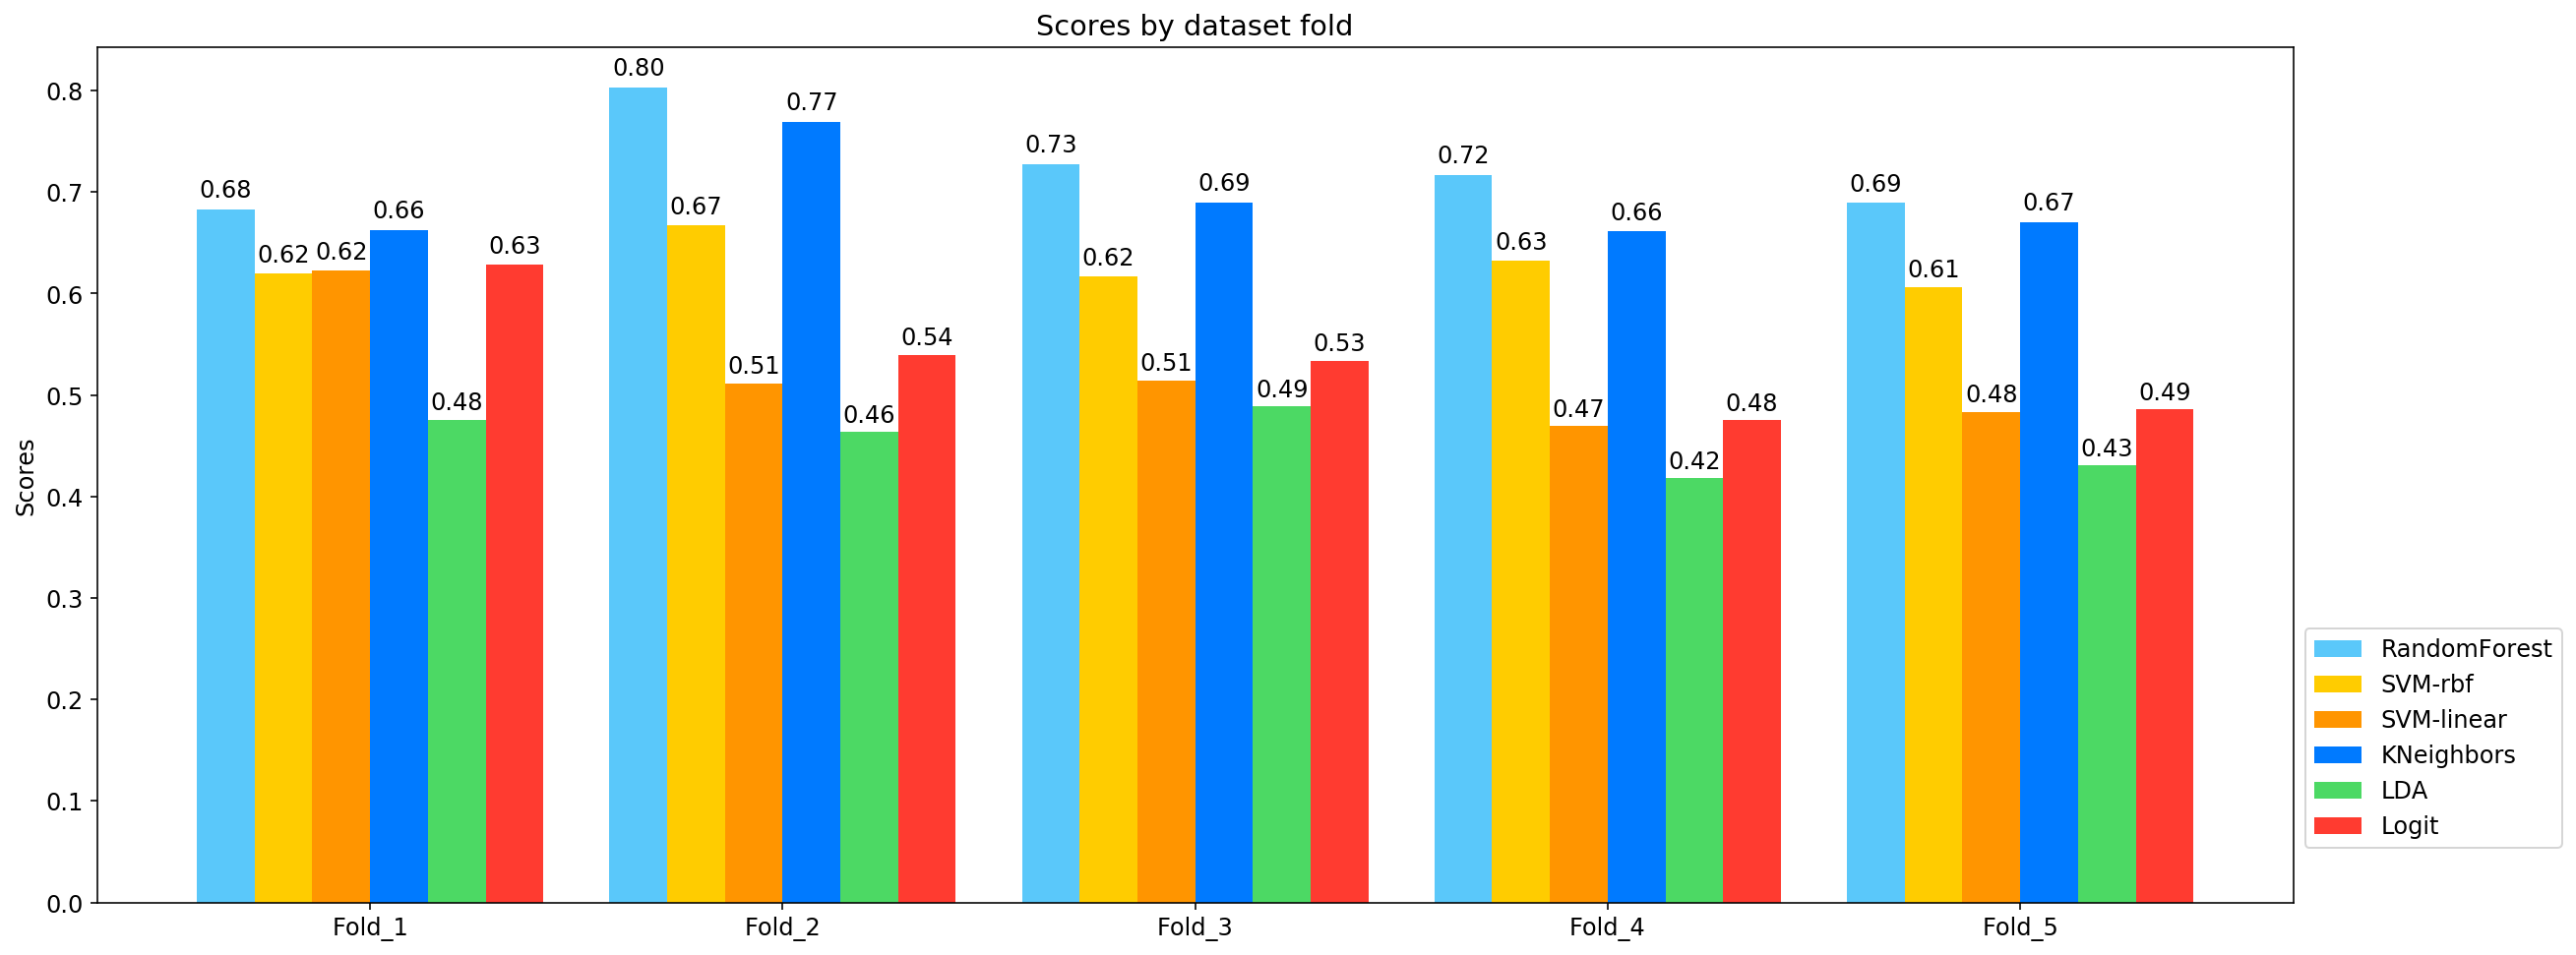

In [10]:
plot_clf_scores('Scores by dataset fold', ('Fold_1', 'Fold_2', 'Fold_3',
                                           'Fold_4', 'Fold_5'))

In [11]:
train_i = [x for x in total if x not in test_indices[2]]
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for j in train_i:
    train_df = train_df.append(
        df[(df.Filename == dataset_rows[j]['Filename']) &
           (df.DataSet == dataset_rows[j]['DataSet']) &
           (df.Table == dataset_rows[j]['Table'])])
for k in test_indices[2]:
    test_df = test_df.append(
        df[(df.Filename == dataset_rows[k]['Filename']) &
           (df.DataSet == dataset_rows[k]['DataSet']) &
           (df.Table == dataset_rows[k]['Table'])])
scores = train_and_test(train_df, test_df, True)

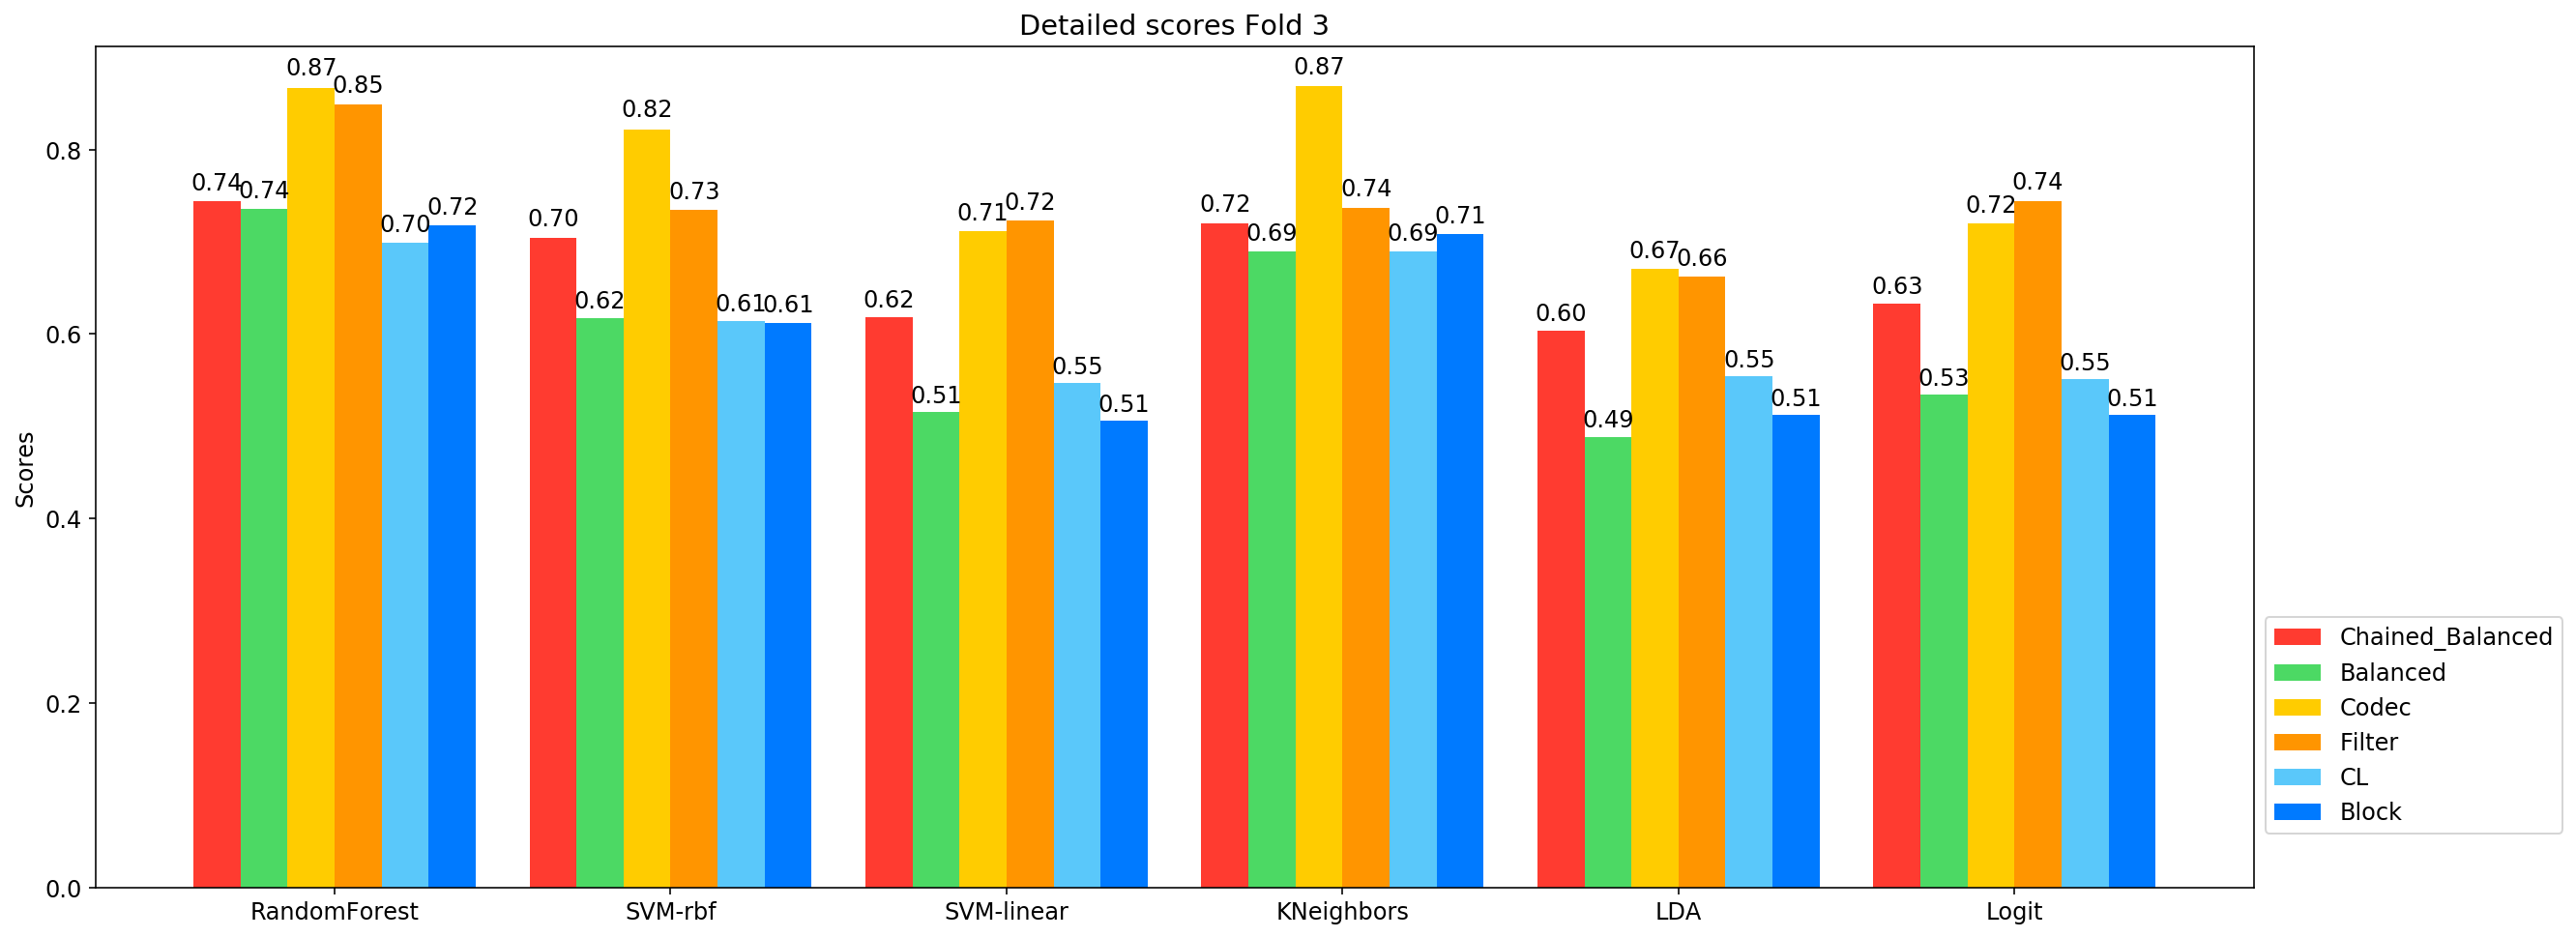

In [12]:
plot_clf_scores('Detailed scores Fold 3', names, detailed=True)

## Puntuaciones CV-Chunk

### Primer chunk vs el resto

In [13]:
dataset_rows = []
for index, row in df[df.Chunk_Number == 2].drop_duplicates(
    subset=['Filename', 'DataSet', 'Table'])[set_id].iterrows():
    dataset_rows.append(row)

all_scores = []
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for j in range(len(dataset_rows)):
    train_df = train_df.append(
        df[(df.Filename == dataset_rows[j]['Filename']) &
           (df.DataSet == dataset_rows[j]['DataSet']) &
           (df.Table == dataset_rows[j]['Table']) &
           (df.Chunk_Number == 1)])
    test_df = test_df.append(
        df[(df.Filename == dataset_rows[j]['Filename']) &
           (df.DataSet == dataset_rows[j]['DataSet']) &
           (df.Table == dataset_rows[j]['Table']) &
           (df.Chunk_Number != 1)])
scores = train_and_test(train_df, test_df, True)

280 train --- 4256 test


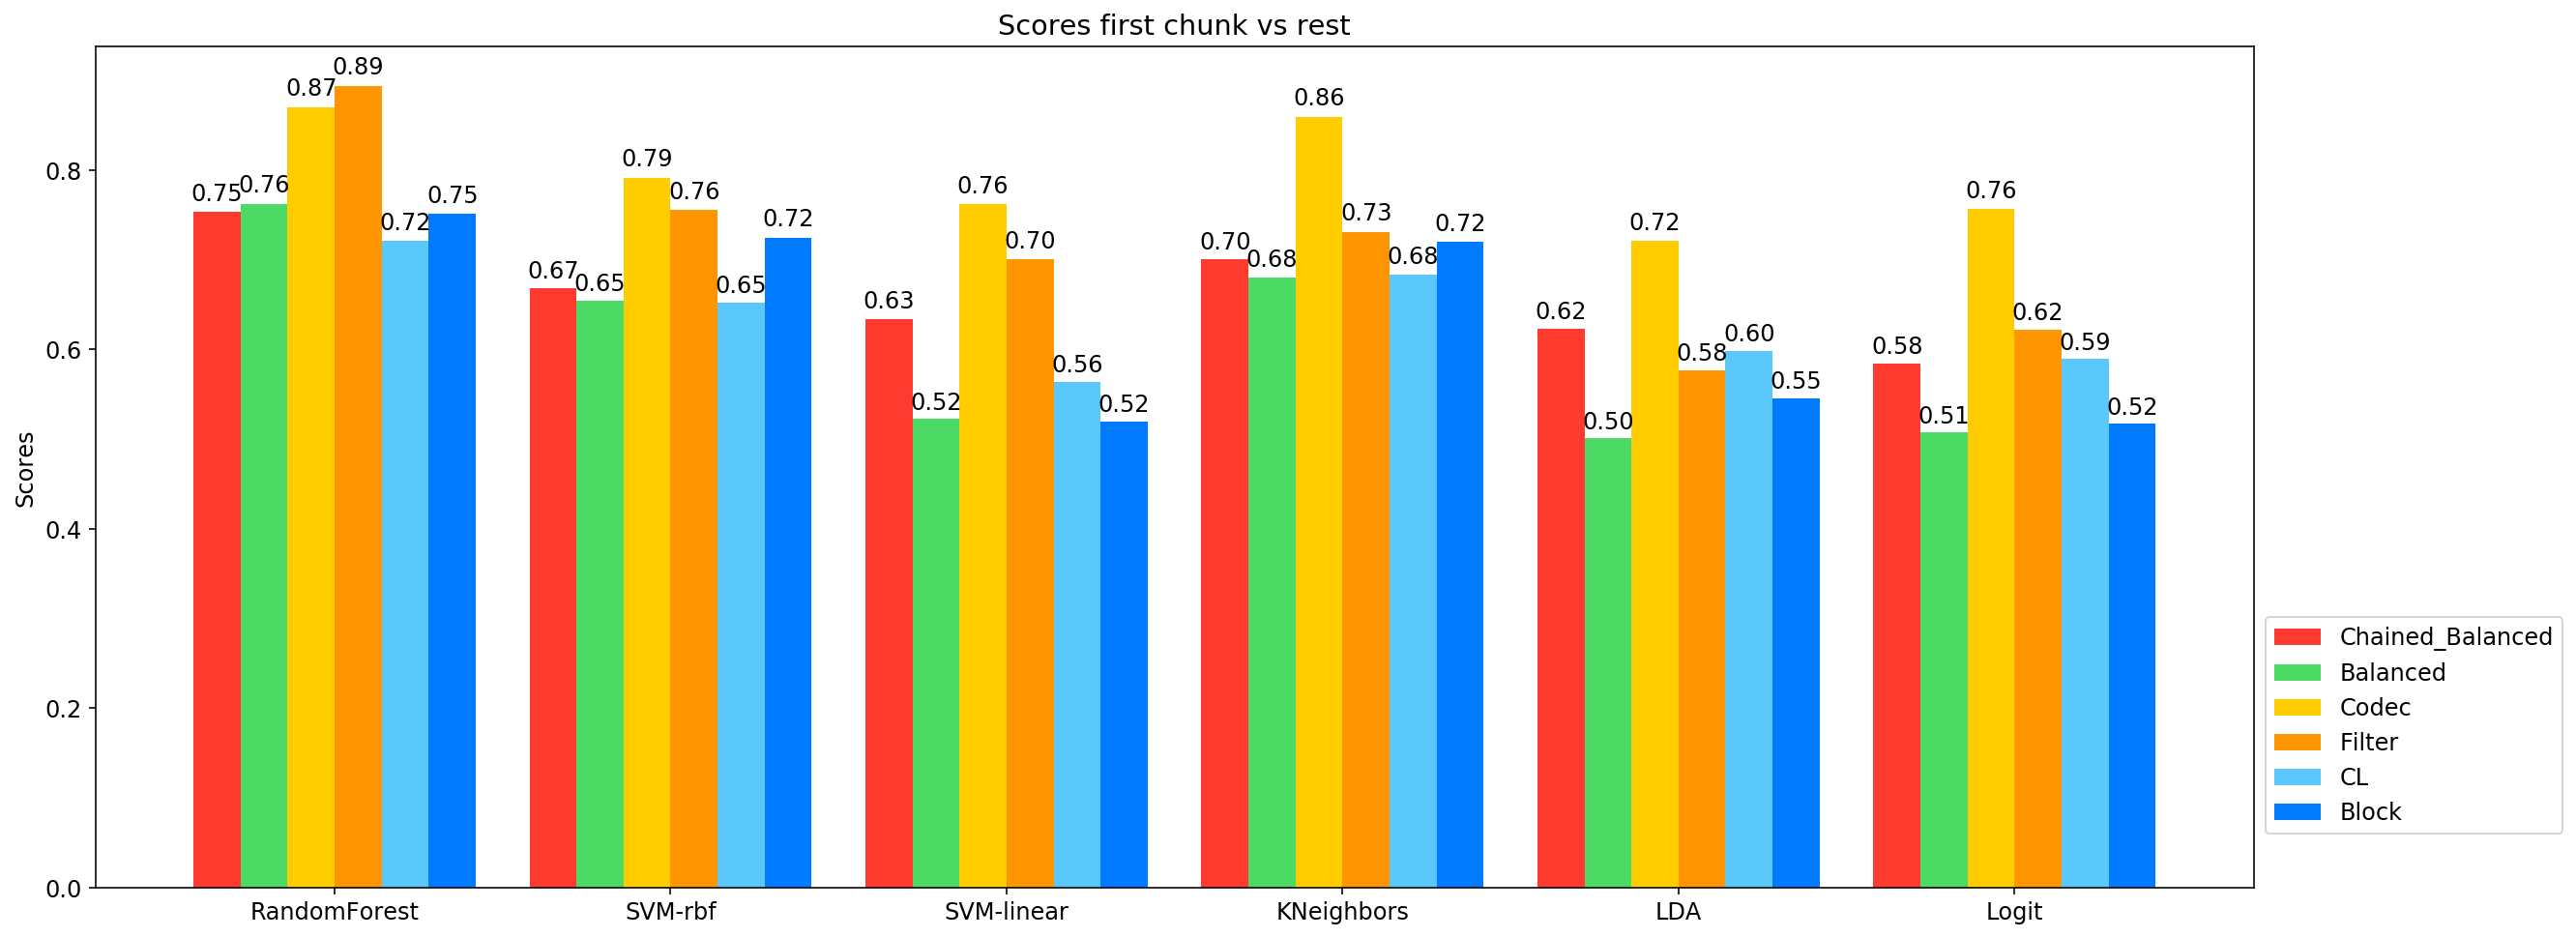

In [14]:
plot_clf_scores('Scores first chunk vs rest', names, detailed=True)
print('%s train --- %s test' % (train_df.shape[0], test_df.shape[0]))

### Chunks únicos mitad vs mitad

In [15]:
sets = []
for index, row in df[df.Chunk_Number == 2].drop_duplicates(
    subset=['Filename', 'DataSet', 'Table']).iterrows():
    sets.append(row['DataSet'])

dataset_rows = df.drop_duplicates(
    subset=['Filename', 'DataSet', 'Table'])[~df.DataSet.isin(sets)]
dataset_rows = dataset_rows.reset_index(drop=True)
 
N = dataset_rows.shape[0]
total = list(range(N))
test_i = random.sample(total, N // 2)
train_i = [x for x in total if x not in test_i]

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for j in train_i:
    train_df = train_df.append(
        df[(df.Filename == dataset_rows.ix[j]['Filename']) &
           (df.DataSet == dataset_rows.ix[j]['DataSet']) &
           (df.Table == dataset_rows.ix[j]['Table'])] )
for k in test_i:
    test_df = test_df.append(
        df[(df.Filename == dataset_rows.ix[k]['Filename']) &
           (df.DataSet == dataset_rows.ix[k]['DataSet']) &
           (df.Table == dataset_rows.ix[k]['Table'])])
scores = train_and_test(train_df, test_df, True)

273 train --- 266 test


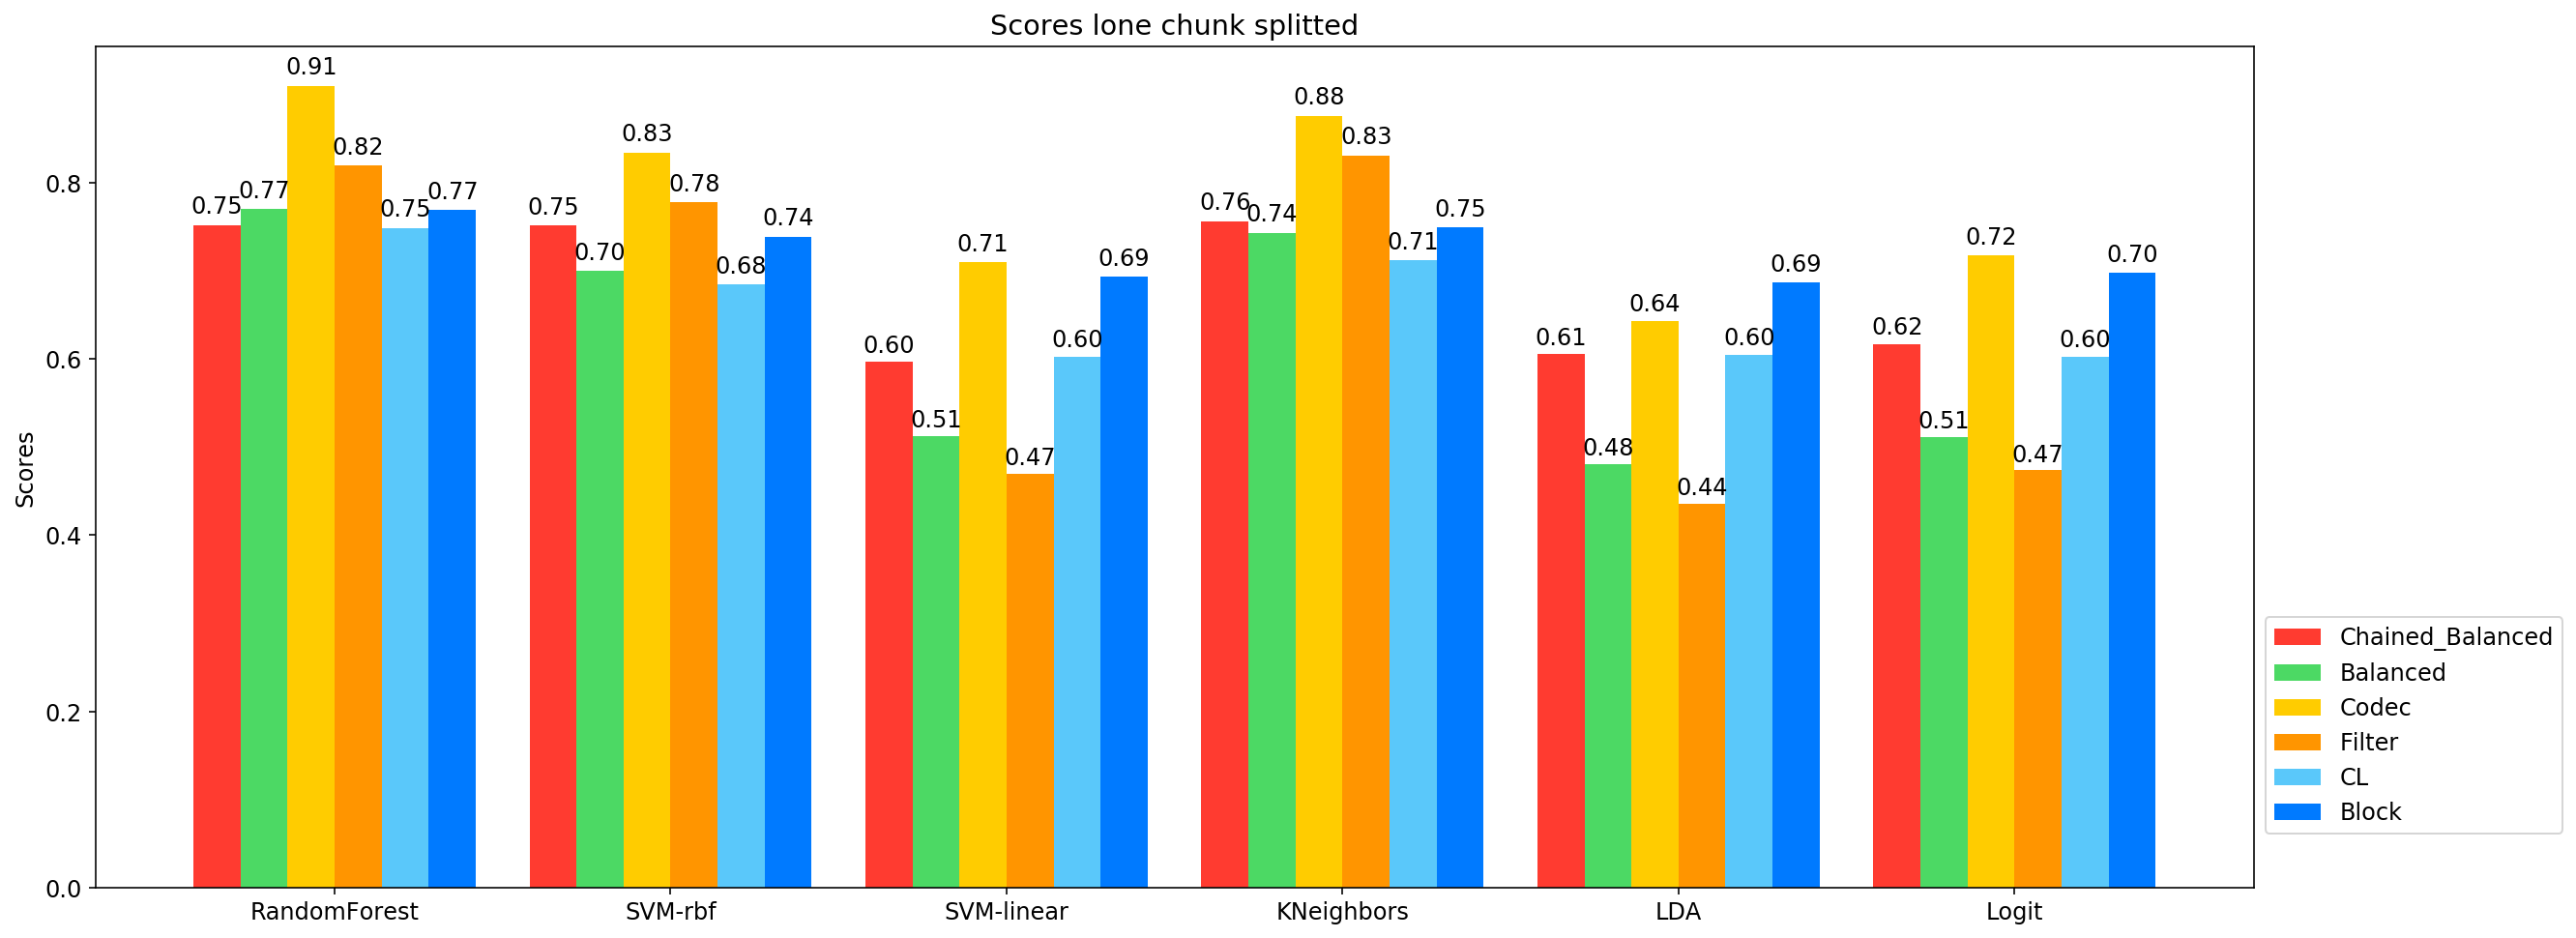

In [16]:
plot_clf_scores('Scores lone chunk splitted', names, detailed=True)
print('%s train --- %s test' % (train_df.shape[0], test_df.shape[0]))

## Velocidades

In [17]:
def atomic_benchmark_estimator(estimator, X_test, verbose=False):
    """Measure runtime prediction of each instance."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_instances, dtype=np.float)
    for i in range(n_instances):
        instance = X_test[[i], :]
        start = time.time()
        estimator.predict(instance)
        runtimes[i] = time.time() - start
    if verbose:
        print("atomic_benchmark runtimes:", min(runtimes), scoreatpercentile(
            runtimes, 50), max(runtimes))
    return runtimes

In [18]:
X, Y = df[CUSTOM_IN].values, df[OUT_OPTIONS].values
runtimes_mean = []
for clf in classifiers:
    shuffle = ShuffleSplit(n_splits=5, test_size=0.5, random_state=5)
    runtimes = []
    for train_index, test_index in shuffle.split(X, Y):
        scaler = StandardScaler().fit(X[train_index])
        X_train, Y_train = scaler.transform(X[train_index]), Y[train_index]
        X_test = scaler.transform(X[test_index])
        clf.fit(X_train, Y_train)
        runtimes.append(atomic_benchmark_estimator(clf, X_test).mean())
    runtimes_mean.append(np.mean(runtimes))

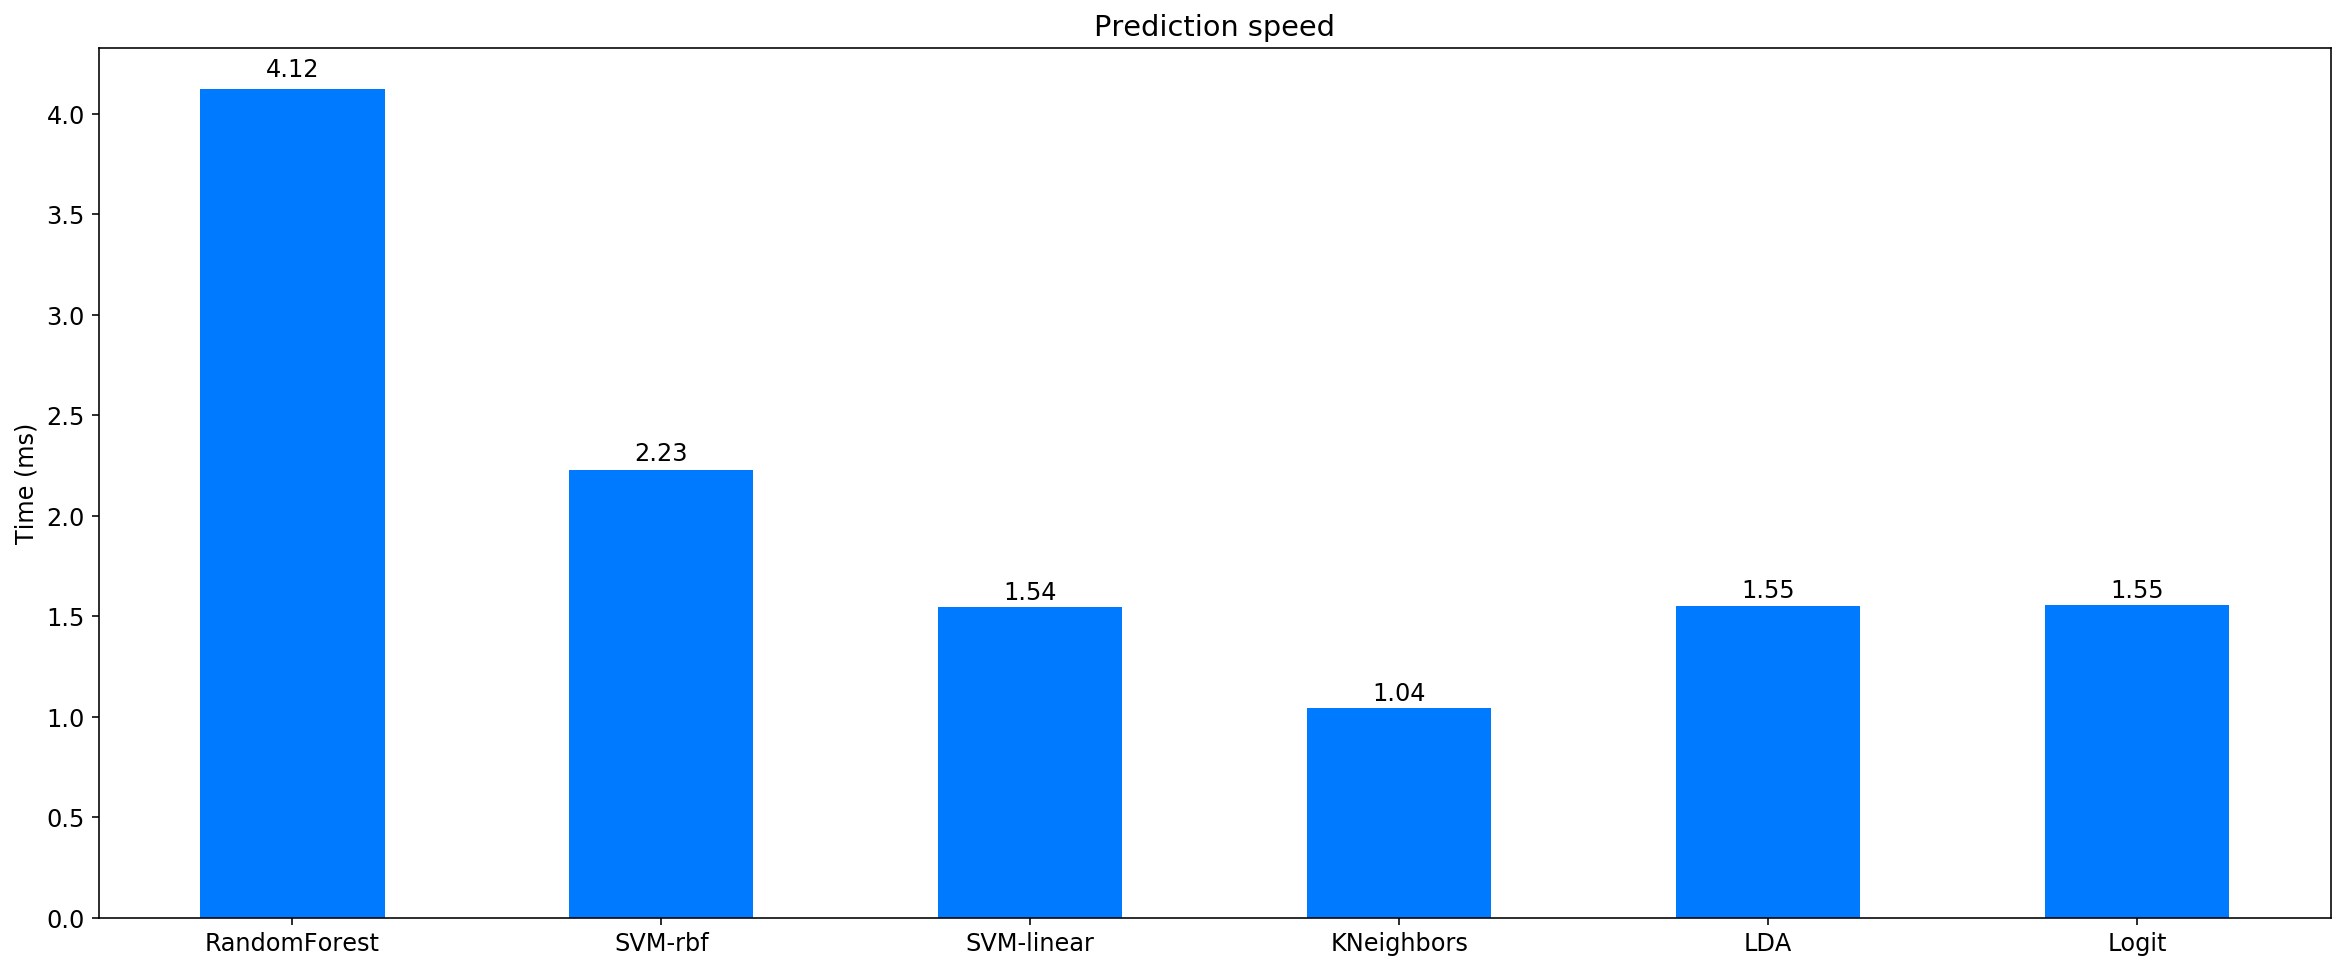

In [20]:
fig = plt.figure(figsize=(20, 8))
width = 0.50
ind = np.arange(len(names))
ax = fig.add_subplot(111)
colors = ['#4CD964', '#FFCC00', '#FF9500', '#5AC8FA', '#007AFF', '#FF3B30']
rects = []
rects.append(
    ax.bar(ind + width * i,
           [e*10**3 for e in runtimes_mean],
           width, color=colors[4]))
ax.set_ylabel('Time (ms)')
ax.set_title('Prediction speed')
ax.set_xticks(ind + width * i)
ax.set_xticklabels(names)

for rec in rects:
    autolabel(ax, rec)